In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nltk.corpus import stopwords

In [2]:
nh = pd.read_csv('../../data/cases_nh.csv')

In [3]:
nh.shape

(1277, 5)

In [4]:
nh.head()

,file name,title,type,decision,text
0,Tarbl099.pdf,"TARBELL ADMINISTRATOR, INC., TRUSTEE OF THE TA...",non-criminal,affirmed in part,"[""NOTICE: This opinion is subject to motions f..."
1,sider051.pdf,THE STATE OF NEW HAMPSHIRE v. GEORGE SIDERIS,non-criminal,not affirmed,"[""NOTICE: This opinion is subject to motions f..."
2,danie080.pdf,RYDER DANIELS & a. v. TOWN OF LONDONDERRY & a.,non-criminal,affirmed,"[""NOTICE: This opinion is subject to motions f..."
3,macdo019.pdf,THE STATE OF NEW HAMPSHIRE v. DAVID A. MACDONALD,non-criminal,affirmed,"[""NOTICE: This opinion is subject to motions f..."
4,liber139.pdf,LIBERTARIAN PARTY OF NEW HAMPSHIRE v. SECRETAR...,non-criminal,not affirmed,"[""NOTICE: This opinion is subject to motions f..."


In [5]:
nh.type.unique() 

array(['non-criminal', 'criminal', nan], dtype=object)

In [7]:
criminal = nh[nh['type']=='criminal']   # there are 269 criminal cases in NH data
criminal.shape   

(269, 5)

In [8]:
criminal.decision.unique()             

array(['not affirmed', 'affirmed', 'affirmed in part'], dtype=object)

In [9]:
criminal.decision = criminal.decision.str.lower().copy()
part =  criminal[criminal.decision.str.contains('part')]
part.shape

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


(9, 5)

In [10]:
no_part = criminal[~criminal.decision.str.contains('part')]
no_part.shape

(260, 5)

In [13]:
affirmed = no_part[no_part.decision=='affirmed']
len(affirmed)

194

In [15]:
reversed = no_part[no_part.decision=='not affirmed']
reversed.shape

(66, 5)

In [16]:

#affirmed = criminal[criminal.decision=='Affirmed.']   # separate the affirmed, reversed, partial reversed cases
#reversed = criminal[criminal.decision=='Reversed.']
#partial_reversed = criminal[criminal.decision!='Affirmed.'][criminal.decision!='Reversed.']

The proportion of affirmed cases is 71.4%, the proportion of reversed cases is 3.3%, the proportion of partial reversed cases is 25.3.

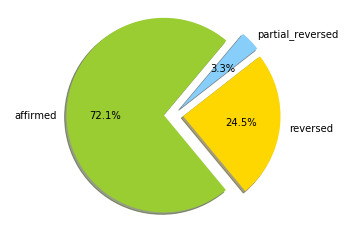

In [17]:
labels='affirmed','reversed','partial_reversed'
sizes= (len(affirmed)/len(criminal))*100,(len(reversed)/len(criminal))*100,(len(part)/len(criminal))*100
colors='yellowgreen','gold','lightskyblue'
explode=0.1,0.1,0.1
plt.pie(x=sizes,explode=explode,labels=labels,colors=colors,autopct='%1.1f%%',shadow=True,labeldistance=1.1,startangle=50,radius=1,counterclock=True)
plt.axis('equal')
plt.show()

In [18]:

informant = criminal[criminal.text.str.contains('informant')]
non_informant =  criminal[~criminal.text.str.contains('informant')]

In [19]:
informant.shape

(15, 5)

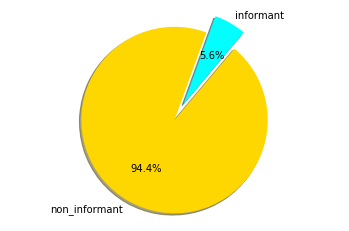

In [20]:
labels='informant','non_informant'
sizes= (len(informant)/len(criminal))*100,(len(non_informant)/len(criminal))*100
colors='aqua','gold'
explode=0.1,0.1
plt.pie(x=sizes,explode=explode,labels=labels,colors=colors,autopct='%1.1f%%',shadow=True,labeldistance=1.1,startangle=50,radius=1,counterclock=True)
plt.axis('equal')
plt.show()

There are some common features in affirmed and reversed, like 'case','court','new hampshire', this words appear many times, but it doesn't make senses. So we delete these words. Meanwhile, there are many numbers in the case. The numbers usually appear in two places: the case number and the law number. We can't tell where the numbers come from. So we delete the number.

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [22]:
def tfidf(X,n):
    vectorizer = TfidfVectorizer(stop_words='english',max_features=n)
    tfidf = vectorizer.fit_transform(X)
    word = vectorizer.get_feature_names()
    return word

In [25]:
criminal_common_word = tfidf(criminal['text'],20)
criminal_common_word+=['might','www','may','two','due','also','iii','even','though','whether', 'http', 'one']
criminal_common_word

['argues',
 'case',
 'counsel',
 'court',
 'defendant',
 'did',
 'evidence',
 'hampshire',
 'id',
 'jury',
 'new',
 'omitted',
 'police',
 'rsa',
 'rule',
 'state',
 'statute',
 'testimony',
 'trial',
 'victim',
 'might',
 'www',
 'may',
 'two',
 'due',
 'also',
 'iii',
 'even',
 'though',
 'whether',
 'http',
 'one']

In [30]:
import re
def clean_common_word(text):           # delect the number, punctuation and criminal_word
    text =  re.sub("[^a-zA-Z#]", " ", text) 
    words=text.lower().split()          # lower case
    words = [w for w in words if len(w)>=3]
    stoplist = stopwords.words('english')
    words = [word for word in words if word not in stoplist]
    words = [word for word in words if word not in criminal_common_word]
    return " ".join(words)

# analyze the affirmed cases and reversed cases

In [31]:
def handle_all_cases(df):
    for i in range(len(df)):
        df.text.iloc[i] = clean_common_word(df.text.iloc[i])
    return df

In [32]:
reversed = handle_all_cases(reversed)
affirmed = handle_all_cases(affirmed)
criminal = handle_all_cases(criminal)
part = handle_all_cases(part)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [37]:
reversed_word = tfidf(reversed['text'],15)     # select the most important 10 features
reversed_word

['assault',
 'child',
 'conduct',
 'criminal',
 'defense',
 'issue',
 'law',
 'motion',
 'officers',
 'opinion',
 'person',
 'quotation',
 'reasonable',
 'sexual',
 'testified']

In [38]:
affirmed_word = tfidf(affirmed['text'],15)
affirmed_word

['assault',
 'conduct',
 'crime',
 'defense',
 'error',
 'following',
 'law',
 'motion',
 'opinion',
 'person',
 'quotation',
 'reasonable',
 'testified',
 'time',
 'witness']

In [39]:
criminal_word = tfidf(criminal['text'],15)
criminal_word

['assault',
 'conduct',
 'crime',
 'criminal',
 'defense',
 'error',
 'law',
 'motion',
 'opinion',
 'person',
 'quotation',
 'reasonable',
 'sexual',
 'testified',
 'time']

In [40]:
part_word = tfidf(part['text'],15)
part_word

['based',
 'charge',
 'conclude',
 'criminal',
 'deadly',
 'doubt',
 'error',
 'fact',
 'harmless',
 'juror',
 'law',
 'nixon',
 'reasonable',
 'statements',
 'weapon']

When we select the most import 15 features in reversed cases and affirmed cases, we found reversed cases contains features: child and sexual. 

# analyze the cases with informant and without

In [41]:
non_informant = handle_all_cases(non_informant)
informant = handle_all_cases(informant)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [42]:
non_informant_word = tfidf(non_informant['text'],10)
non_informant_word

['assault',
 'conduct',
 'defense',
 'error',
 'law',
 'person',
 'quotation',
 'reasonable',
 'sexual',
 'time']

In [43]:
informant_word = tfidf(informant['text'],10)
informant_word

['constitution',
 'home',
 'informant',
 'information',
 'reasonable',
 'search',
 'statements',
 'told',
 'warrant',
 'witness']

# reversed cases with informant

In [44]:
informant_in_reverse = reversed[reversed.text.str.contains('informant')]
non_informant_in_reverse =  reversed[~reversed.text.str.contains('informant')]

In [45]:
informant_in_reverse

,file name,title,type,decision,text
210,robin076.pdf,THE STATE OF NEW HAMPSHIRE v. SCOTT ROBINSON,criminal,not affirmed,notice opinion subject motions rehearing well ...
334,2010042nieve.pdf,THE STATE OF NEW HAMPSHIRE v. SOILUIS NIEVES,criminal,not affirmed,notice opinion subject motions rehearing well ...
348,2010039parke.pdf,2008-886 THE STATE OF NEW HAMPSHIRE v. ANTHONY...,criminal,not affirmed,notice opinion subject motions rehearing well ...


In [46]:
non_info_r_word = tfidf(non_informant_in_reverse['text'],10)
non_info_r_word

['assault',
 'conduct',
 'criminal',
 'defense',
 'issue',
 'motion',
 'person',
 'quotation',
 'reasonable',
 'sexual']

In [47]:
info_r_word = tfidf(informant_in_reverse['text'],10)
info_r_word

['circumstances',
 'confidentiality',
 'detective',
 'home',
 'officer',
 'officers',
 'promise',
 'requirement',
 'search',
 'warrant']

The reversed cases with informant is not related to child and sexual. 

# affirmed cases with informant

In [48]:
informant_in_affirmed = affirmed[affirmed.text.str.contains('informant')]
non_informant_in_affirmed =  affirmed[~affirmed.text.str.contains('informant')]

In [49]:
info_a_word = tfidf(informant_in_affirmed['text'],10)
info_a_word

['constitution',
 'crime',
 'informant',
 'information',
 'instruction',
 'murder',
 'reasonable',
 'search',
 'statements',
 'witness']

In [50]:
non_info_a_word = tfidf(non_informant_in_affirmed['text'],10)
non_info_a_word

['assault',
 'defense',
 'error',
 'law',
 'opinion',
 'person',
 'quotation',
 'reasonable',
 'testified',
 'time']

In affirmed cases with informant, the feature 'murder' may be important 

# similarity 

In [51]:
a = []
for i in range(len(reversed)):
    a.append(reversed.text.iloc[i].split(' '))
    

In [52]:
#a = reversed.text.iloc[24].split(' ')

In [53]:
from gensim.models import Word2Vec

In [54]:
word2vec_model =Word2Vec(a,min_count=10)


In [55]:
print(word2vec_model)

Word2Vec(vocab=2390, size=100, alpha=0.025)


In [56]:
word2vec_model.wv.most_similar('reversed')

[('remanded', 0.9986464977264404),
 ('dissented', 0.9959361553192139),
 ('superior', 0.9943211674690247),
 ('broderick', 0.9942866563796997),
 ('conflict', 0.9933634996414185),
 ('appointed', 0.993209958076477),
 ('johnson', 0.9921435713768005),
 ('dugas', 0.9921237826347351),
 ('green', 0.9920369386672974),
 ('respondent', 0.9920048117637634)]

In [57]:
reversed.iloc[0]

file name                                         kornb023.pdf
title            THE STATE OF NEW HAMPSHIRE v. KARL KORNBREKKE
type                                                  criminal
decision                                          not affirmed
text         notice opinion subject motions rehearing well ...
Name: 6, dtype: object

In [58]:
b=reversed.text.iloc[0].split(' ')


In [59]:
word2vec_model1 =Word2Vec([b],min_count=1)


In [339]:
word2vec_model1.wv.most_similar('reversed')

[('meritorious', 0.6856645345687866),
 ('with', 0.6722795963287354),
 ('when', 0.6688871383666992),
 ('this', 0.6684521436691284),
 ('questions', 0.6663250923156738),
 ('very', 0.6662308573722839),
 ('no', 0.6647916436195374),
 ('also', 0.6647704839706421),
 ('n', 0.6646958589553833),
 ('we', 0.6638684272766113)]

In [65]:
c = []
for i in range(len(criminal)):
    c.append(criminal.text.iloc[i].split(' '))

In [66]:
word2vec_model2 =Word2Vec(c,min_count=10)

In [67]:
word2vec_model2.wv.most_similar('reversed')

[('remanded', 0.9685547947883606),
 ('vacated', 0.9636162519454956),
 ('dalianis', 0.9338315725326538),
 ('broderick', 0.9320261478424072),
 ('conboy', 0.9178599119186401),
 ('hicks', 0.913033664226532),
 ('duggan', 0.9049065113067627),
 ('resentencing', 0.9004073143005371),
 ('affirmed', 0.8975157737731934),
 ('tucker', 0.8858725428581238)]